In [2]:
import transformers
from datasets import load_dataset

In [22]:
from transformers import ViTFeatureExtractor

In [3]:
beans = load_dataset('beans')#, split="train[:5000]"

Using custom data configuration default


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /Users/akarsha.sehwag/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
labels= beans['train'].features['labels']
labels

ClassLabel(num_classes=3, names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

In [4]:
beans

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

healthy


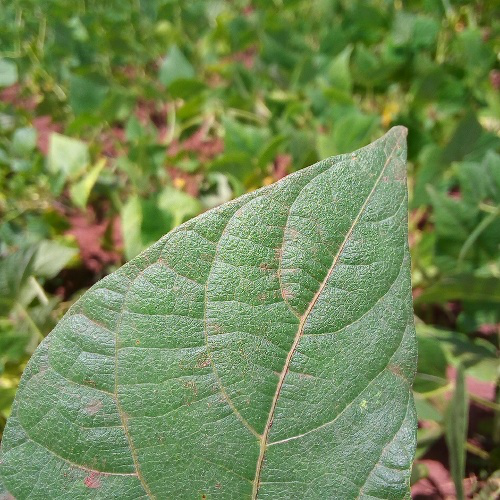

In [21]:
x = beans['train'][50]
print( labels.int2str(x['labels']))
x['image']

In [24]:
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [27]:
feature_extractor(x['image'], return_tensors='pt')

{'pixel_values': tensor([[[[-0.2078, -0.2863, -0.3725,  ..., -0.4588, -0.4745, -0.4824],
          [-0.2157, -0.3412, -0.4039,  ..., -0.4745, -0.5059, -0.5216],
          [-0.1922, -0.3020, -0.3647,  ..., -0.4745, -0.5373, -0.5843],
          ...,
          [ 0.1137,  0.1451,  0.1686,  ...,  0.4588,  0.3412,  0.0275],
          [ 0.2157,  0.2157,  0.1922,  ...,  0.4118,  0.2157, -0.1843],
          [ 0.2627,  0.2235,  0.1608,  ...,  0.2078, -0.1059, -0.3725]],

         [[ 0.0039, -0.0667, -0.1059,  ..., -0.2941, -0.2863, -0.2941],
          [-0.0039, -0.1137, -0.1294,  ..., -0.3020, -0.3098, -0.3176],
          [ 0.0353, -0.0667, -0.0980,  ..., -0.2863, -0.3176, -0.3569],
          ...,
          [ 0.2000,  0.2314,  0.2235,  ...,  0.2078,  0.1373, -0.1686],
          [ 0.2392,  0.2078,  0.1608,  ...,  0.2157, -0.0196, -0.4118],
          [ 0.2392,  0.1765,  0.0980,  ...,  0.0510, -0.3255, -0.5922]],

         [[-0.4824, -0.5765, -0.6314,  ..., -0.9608, -0.9765, -0.9686],
          [-0

In [28]:
def transform(batch):
    inp = feature_extractor([x for x in batch['image']], return_tensors='pt')
    inp['labels'] = batch['labels']
    return inp

In [29]:
ds = beans.with_transform(transform)


In [37]:
ds['train'][0:2]['pixel_values'].shape

torch.Size([2, 3, 224, 224])

## Before we train:

    Define a collate function.

    Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. You should define a compute_metrics function accordingly.

    Load a pretrained checkpoint. You need to load a pretrained checkpoint and configure it correctly for training.

    Define the training configuration.


In [48]:
import numpy as np
import torch
from transformers import ViTForImageClassification, TrainingArguments, Trainer
from datasets import load_metric

In [41]:
def collate(batch):
    return { 'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
             'labels': torch.tensor([x['labels'] for x in batch])}
# torch.as_tensor

In [42]:
# accuracy is good-enough for now.. gives us the top-1 
metric = load_metric('accuracy')

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions,axis=1), references=p.label_ids)

In [45]:
# load pretrained model
labels = ds['train'].features['labels'].names
model = ViTForImageClassification.from_pretrained(
            model_name,
            num_labels=len(labels),
            id2label={str(i): c for i,c in enumerate(labels)},
            label2id={c: str(i) for i,c in enumerate(labels)}  )


Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
training_args = TrainingArguments(
        output_dir= "./vit-beans",
        per_device_train_batch_size=16,
        evaluation_strategy='steps',
        #fp16=True, # True for GPUs
        num_train_epochs=4,
        save_steps=100,
        eval_steps=100,
        logging_steps=10,
        learning_rate=2e-4,
        save_total_limit=2,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to='tensorboard',
        load_best_model_at_end=True  )

In [56]:
trainer = Trainer( 
                model=model,
                args=training_args,
                data_collator=collate,
                compute_metrics=compute_metrics,
                train_dataset=ds['train'],
                eval_dataset=ds['validation'],
                tokenizer=feature_extractor,)

In [57]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


/Users/akarsha.sehwag/opt/miniconda3/envs/imgenv/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1034
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 260


Step,Training Loss,Validation Loss,Accuracy
100,0.114100,0.087407,0.977444
200,0.018000,0.014180,1.000000


***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-beans/checkpoint-100
Configuration saved in ./vit-beans/checkpoint-100/config.json
Model weights saved in ./vit-beans/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-beans/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 133
  Batch size = 8
Saving model checkpoint to ./vit-beans/checkpoint-200
Configuration saved in ./vit-beans/checkpoint-200/config.json
Model weights saved in ./vit-beans/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-beans/checkpoint-200/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./vit-beans/checkpoint-200 (score: 0.014179646037518978).
Saving model checkpoint to ./vit-beans
Configuration saved in ./vit-beans/config.json
Model weights saved in ./vit-beans/pytorch_model.bin
Feature extractor saved in ./

***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1197
  train_runtime            = 18:55:34.05
  train_samples_per_second =       0.061
  train_steps_per_second   =       0.004


In [58]:
metrics = trainer.evaluate(ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 133
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =        1.0
  eval_loss               =     0.0142
  eval_runtime            = 0:06:40.44
  eval_samples_per_second =      0.332
  eval_steps_per_second   =      0.042


In [59]:
#from transformers import onnx

In [ ]:
#save_pretrained('./saved_model/')